In [1]:
import functions as utils
from classes import Two_SLS
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd

### 4. Weak Instruments


##### 4.2.b 

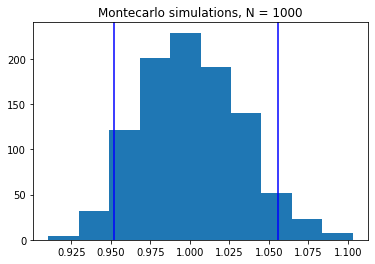

t-test: 
 54.840681460434176

p-value of t-test:
 0.0

2SLS 95% CI: 
 (0.96513922015514, 1.036845689118945)

Monte Carlo 95% CI: 
 (0.952045568561403, 1.0555730290270462)


In [2]:
n = 1000
beta = 1 
pi = 1

monte_carlo_outputs = np.array([utils.do_two_sls(n, beta, pi) for i in range(1000)])
b = monte_carlo_outputs[:,0]
mean_hyp_vals = monte_carlo_outputs[:,1:].mean(0)

monte_carlo_5 = np.percentile(b, 5)
monte_carlo_95 = np.percentile(b, 95)
fig, ax = plt.subplots(1, 1)
ax.hist(b)
ax.set_title(f"Montecarlo simulations, N = {n}")
ax.axvline(x = monte_carlo_5, color = 'b')
ax.axvline(x = monte_carlo_95, color = 'b')
ax.set_title(f"Montecarlo simulations, N = {n}")
plt.show()


print(f"t-test: \n {mean_hyp_vals[0]}\n")
print(f"p-value of t-test:\n {mean_hyp_vals[1]}\n")
print(f"2SLS 95% CI: \n {(mean_hyp_vals[2],mean_hyp_vals[3])}\n")
print(f"Monte Carlo 95% CI: \n {(monte_carlo_5, monte_carlo_95)}")

##### 4.2.c

KeyboardInterrupt: 

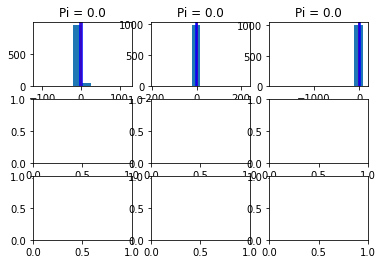

In [3]:
n = 1000
pi = np.exp(np.linspace(np.log(0.0001),0,9))
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
ttest = np.empty(0)
pval = np.empty(0)
for i, coef in enumerate(pi): 
    monte_carlo_outputs = np.array([utils.do_two_sls(n, beta, coef) for i in range(1000)])
    b = monte_carlo_outputs[:,0]
    mean_hyp_vals = monte_carlo_outputs[:,1:].mean(0)
    
    monte_carlo_5 = np.percentile(b, 5)
    monte_carlo_95 = np.percentile(b, 95)

    # get ttest and pval of single draw for each pi
    x, y, Z = utils.dgp(n, beta, coef)
    model = Two_SLS(y, x, Z)
    ttest = np.append(ttest, mean_hyp_vals[0])
    pval = np.append(pval, mean_hyp_vals[1])

    ax[i].hist(b)
    ax[i].set_title(f"Pi = {np.round(coef, 2)}")
    ax[i].axvline(x=1, color='r', label='True beta')
    ax[i].axvline(x = monte_carlo_5, color = 'b')
    ax[i].axvline(x = monte_carlo_95, color = 'b')
fig.tight_layout()
plt.show()


print(pd.DataFrame({'pi': pi, 'ttest': ttest, 'pval': pval}))

##### 4.3.a

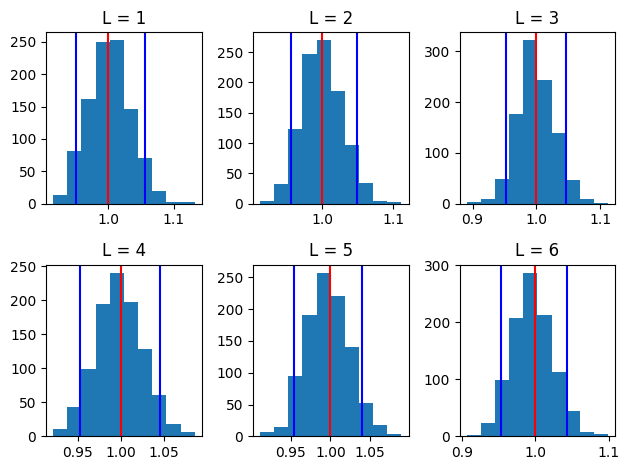

[0.12785512 0.11222578 0.1124172  0.10692911 0.10562598 0.10845019]


In [ ]:
n = 1000
beta = 1
N = 6
L = range(1, N+1)

fig, ax = plt.subplots(2, 3)
ax = ax.reshape(-1)
coverage = np.empty(0)
for l in L: 
    i = l-1
    pi = np.array([(.5)**(x) for x in range(l)])
    monte_carlo_outputs = np.array([utils.do_two_sls(n, beta, coef) for i in range(1000)])
    b = monte_carlo_outputs[:,0]
    coverage = np.append(coverage, utils.calc_coverage(b))
    monte_carlo_5 = np.percentile(b, 5)
    monte_carlo_95 = np.percentile(b, 95)

    ax[i].hist(b)
    ax[i].set_title(f"L = {l}")
    ax[i].axvline(x=1, color='r', label='True beta')
    ax[i].axvline(x = monte_carlo_5, color = 'b')
    ax[i].axvline(x = monte_carlo_95, color = 'b')
    fig.tight_layout()
plt.show()

print(coverage)